In [3]:
import xgboost
#xgboost faces issue with apple silicon m1 , m2 but reinstiagted kernel env.
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns


In [7]:
# Load data
ce_data = pd.read_csv('../outputs/airbnb_cleaned_encoded.csv')
X = ce_data.drop('price', axis=1)
y = ce_data['price']

#TrainTestSplit Training & Testing purpose setting test_size = 0.2 & randomstate = 42
X_train, X_test, y_train , y_test = train_test_split(X,y,test_size=0.20,random_state=42)

In [17]:
#Training XG Boost Regressor 
xgb_model = XGBRegressor(random_state=42)
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

rmse_xgb = mean_squared_error(y_test, y_pred, squared=False)
mae_xgb = mean_absolute_error(y_test, y_pred)
r2_xgb = r2_score(y_test, y_pred)

print("⚡ XGBoost Results:")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.4f}")



⚡ XGBoost Results:
RMSE: 72.24
MAE: 37.33
R²: 0.4196


In [48]:
from sklearn.model_selection import RandomizedSearchCV
#Tuning XG Boost Regressor for better performance and accuracy.

parameter_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 1, 5]
}

xgb = XGBRegressor(random_state=42)

# RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=parameter_grid,
    n_iter=50,  # You can adjust to 30–50 for deeper tuning
    scoring='neg_root_mean_squared_error',
    cv=5,
    verbose=2,
    random_state=60,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

print("✅ Best Params:", random_search.best_params_)
print("📉 Best CV RMSE:", -random_search.best_score_)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END colsample_bytree=1.0, gamma=5, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=5, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=5, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=5, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=5, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.1, max_depth=3, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.1, max_depth=3, n_estimators=500, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.1, max_depth=3

In [49]:
# Tuned XG Boost Metrics 
best_xgb = random_search.best_estimator_
y_pred_tuned = best_xgb.predict(X_test)

rmse_tuned = mean_squared_error(y_test, y_pred_tuned, squared=False)
mae_tuned = mean_absolute_error(y_test, y_pred_tuned)
r2_tuned = r2_score(y_test, y_pred_tuned)

print("🎯 Tuned XGBoost Results:")
print(f"RMSE: {rmse_tuned:.2f}")
print(f"MAE: {mae_tuned:.2f}")
print(f"R²: {r2_tuned:.4f}")


🎯 Tuned XGBoost Results:
RMSE: 60.83
MAE: 34.39
R²: 0.5885


In [50]:
results = pd.DataFrame([
    ['XGBoost (baseline)', rmse_xgb, mae_xgb, r2_xgb],
    ['Tuned XGBoost', rmse_tuned, mae_tuned, r2_tuned]
], columns=['Model', 'RMSE', 'MAE', 'R2'])

results.to_csv('../outputs/model_comparisons_xgb.csv', index=False)
results

,Model,RMSE,MAE,R2
0,XGBoost (baseline),72.244231,37.333484,0.419567
1,Tuned XGBoost,60.825935,34.389851,0.588544


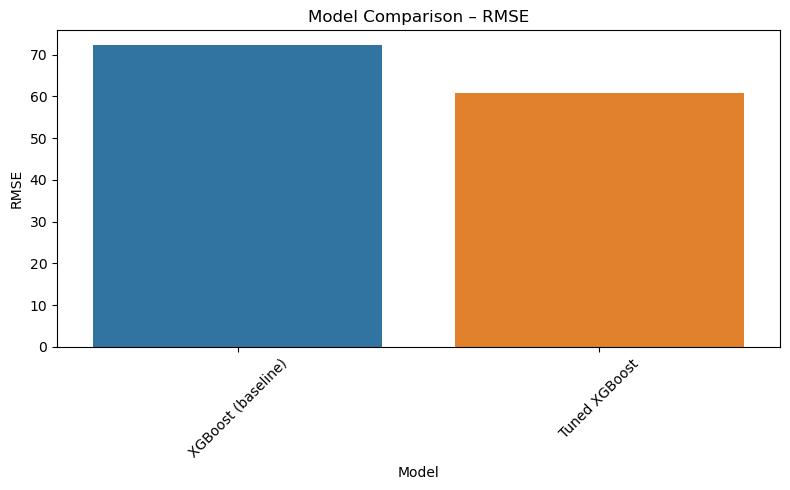

In [47]:
plt.figure(figsize=(8, 5))
sns.barplot(data=results, x='Model', y='RMSE')
plt.xticks(rotation=45)
plt.title('Model Comparison – RMSE')
plt.tight_layout()
plt.show()
